# HW10

## Image/Audio Analysis and Classification with Clustering and PCA


### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework

In [ ]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/audio_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/HW04/raw/main/HW04_utils.pyc
!wget -q https://github.com/DM-GY-9103-2024F-H/HW06/raw/main/HW06_utils.pyc

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import random

from os import listdir, path
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

from audio_utils import wav_to_list

from data_utils import PCA, RandomForestClassifier, StandardScaler, SVC
from data_utils import classification_error, display_confusion_matrix
from data_utils import LFWUtils

from image_utils import make_image, open_image

## Face Unlock

Let's train a model to detect our face. We can think of this as a simpler version of one of the components inside something like the face ID software on our phones.

We'll skip the face detection part, which is when we find faces in an image, and assume we can get cropped and aligned faces out of images or video streams. We'll look at face detection later in the semester.

This is a slightly different kind of problem from the classification exercise we did in class, but the process is mostly the same.

We will use a dataset with other people's faces, but in the end we are only interested on how well our model detects our face.

### We Always Start with the Data

The dataset we're using is inside `./data/images/lfw/cropped`. It's a subset of the [Labeled Faces in the Wild](https://vis-www.cs.umass.edu/lfw/) dataset.

Take a look at the directory.

What's there?

How's the data organized and labeled?

### Loading the Data

Since we're not interested in generic classification, and measuring how we do on unlabeled data, this whole dataset is labeled, and we can read it into `train` and `test` subsets by calling the `train_test_split()` function of the `LFWUtils` class.

This function takes an optional parameter that specifies what portion of the data should be used for the `test` dataset. We can start with the default value of $0.5$.

In [62]:
train, test = LFWUtils.train_test_split(0.5)

### Looking at the Data

Ok. Data is loaded.

What's in the data? How is it actually organized?

Take a look at the objects that were returned in each of the $2$ variables.

How big are our datasets?

Take a look at the `LABELS` and `L2I` members of the `LFWUtils` class.

In [63]:
# TODO: look at dataset objects. What's in them?
# print(type(train))
print(train.keys())
# for key, value in train.items():
#     print(key, ":", value)
# Inspect the types and lengths of the datasets
train_size = len(train["labels"])
print(train_size)
test_size = len(test["labels"])
print(test_size)
# TODO: how big are them?
# TODO: how many labels do they have?


dict_keys(['pixels', 'labels', 'files'])
456
448


### Visualizing the Data

We can open some random images to make sure the content of our datasets make sense:

id: 13 
label: koizumi 
from: koizumi-009.jpg


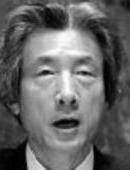

id: 16 
label: mauresmo 
from: mauresmo-017.jpg


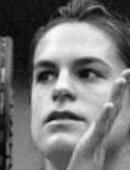

id: 22 
label: sukarnoputri 
from: sukarnoputri-003.jpg


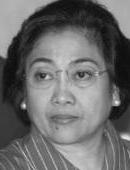

id: 18 
label: powell 
from: powell-034.jpg


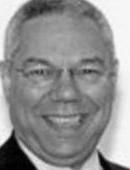

id: 21 
label: schwarzenegger 
from: schwarzenegger-034.jpg


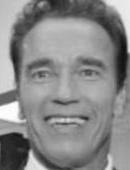

id: 2 
label: arroyo 
from: arroyo-015.jpg


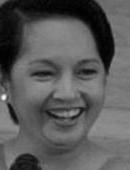

id: 11 
label: giuliani 
from: giuliani-016.jpg


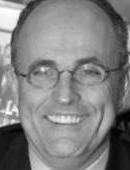

id: 19 
label: putin 
from: putin-043.jpg


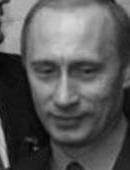

id: 7 
label: chavez 
from: chavez-018.jpg


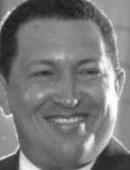

id: 19 
label: putin 
from: putin-018.jpg


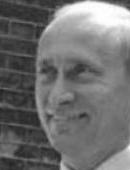

In [64]:
train_size = len(train["labels"])

for idx in [random.randint(0, train_size - 1) for cnt in range(10)]:
  label_id = train["labels"][idx]
  print("id:", label_id,
        "\nlabel:", LFWUtils.LABELS[label_id],
        "\nfrom:", train["files"][idx])
  display(make_image(train["pixels"][idx], width=130))

### Adding your images

Create a directory in the `dataset` directory for your images. Give it a one-word name, like your last name, your nyu id or your initials. For example, mine is called `tgh` and is located at: `./data/images/lfw/cropped/tgh`.

Now, add between $20$ and $30$ images of your face to your directory. 

The images should be just like the ones that are already there for the other people:
- $130$ pixels wide by 
- $170$ pixels tall
- single-channel grayscale
- jpeg format
- named `label-number.jpg` (for example: `tgh-000.jpg`)

Feel free to do this manually using Photoshop or any other image editing software, but the easiest way is to use this interface that automatically crops faces out of pictures and creates images in the correct format:

https://huggingface.co/spaces/thiagohersan/face-align

It will also align the faces and put the eyes in a consistent location. There's even an option to capture pictures from a live camera stream.

### PCA, Classification, etc etc etc

Now that we have added our images to the dataset, let's train a classifier and see how well it performs on not just classification, but on recognizing our face.

We can aim for an explained variance value of about $80\%$, and adjust that later if we find necessary.

Once we have the PCs for our training dataset in a `DataFrame` we can add a `label` column to it with the correct labels we have in `train["labels"]`.

We can also create a `DataFrame` for testing now by using the same `PCA` object to `transform()` the `test["pixels"]` data.

Since we won't train anything with the test dataset, it's ok to just keep the labels in `test["labels"]` as they are.

In [65]:
# # TODO: reload the dataset, now with our images
# # TODO: create PCA, fit and transform train data
# train_df = pd.DataFrame.from_records(train)
# train_df
# # TODO: check PCA captured variance
pca =PCA(n_components = 200)
train_df = pca.fit_transform(train['pixels'])

# TODO: prepare DataFrame for training (add label column)
train_label_df = pd.DataFrame(train['labels'])
train_df['label'] = train['labels']
# TODO: create the test DataFrame by running PCA on the test data
test_df = pca.transform(test['pixels'])

We can use the following cell to take a look at our images and their reconstructions.

Run the following to look at the first $5$ images of a given label and their re-constructed versions.

This assumes the `DataFrame` is called `train_df` and the `PCA` object is called `face_pca`. Adjust these if necessary.

label: ali 
from: ali_017.jpeg


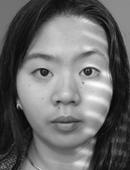

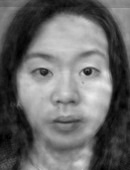

label: ali 
from: ali_010.jpeg


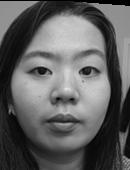

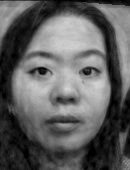

label: ali 
from: ali_004.jpeg


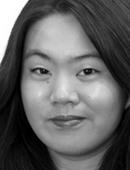

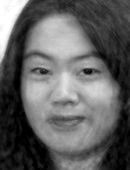

label: ali 
from: ali_20.jpeg


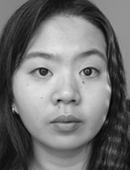

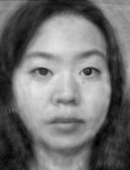

label: ali 
from: ali_007.jpeg


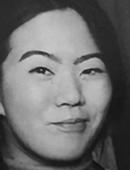

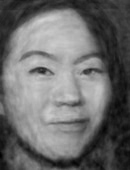

In [66]:
# TODO: change this label to your label to see how
#       your images are being encoded
awesome_label = "ali"
awesome_id = LFWUtils.L2I[awesome_label]

# this filters the DataFrame by our label
awesome_df = train_df[train_df["label"] == awesome_id]

# reconstruct all images
pca_pixels = pca.inverse_transform(awesome_df)

# associate the original indexes with the reconstructed pca pixels
idx_pca = zip(awesome_df.index, pca_pixels.values)

# iterate through indexes and pca pixels
for img_idx, img_pca in list(idx_pca)[:5]:
  print("label:", awesome_label,
        "\nfrom:", train["files"][img_idx])
  display(make_image(train["pixels"][img_idx], width=130))
  display(make_image(img_pca, width=130))

And this cell will look at some random images and their reconstructions.

id: 13 
label: koizumi 
from: koizumi-044.jpg


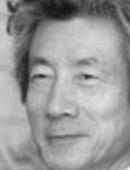

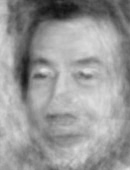

id: 22 
label: sukarnoputri 
from: sukarnoputri-021.jpg


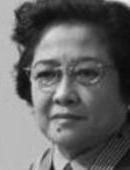

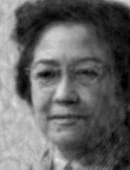

id: 2 
label: arroyo 
from: arroyo-030.jpg


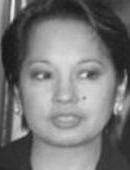

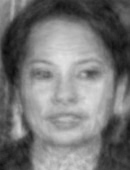

id: 18 
label: powell 
from: powell-020.jpg


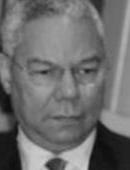

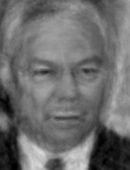

id: 22 
label: sukarnoputri 
from: sukarnoputri-020.jpg


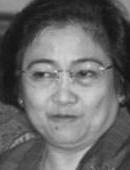

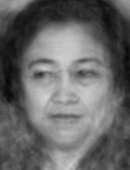

id: 10 
label: fox 
from: fox-018.jpg


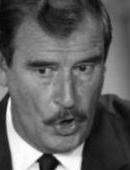

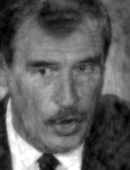

id: 13 
label: koizumi 
from: koizumi-025.jpg


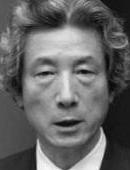

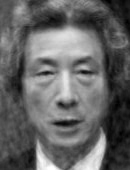

id: 15 
label: lula 
from: lula-039.jpg


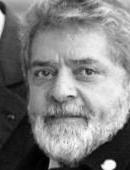

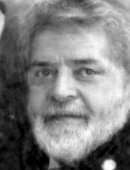

id: 21 
label: schwarzenegger 
from: schwarzenegger-012.jpg


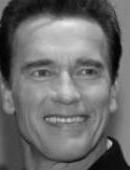

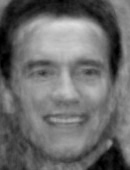

id: 11 
label: giuliani 
from: giuliani-001.jpg


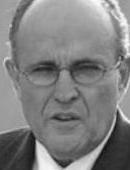

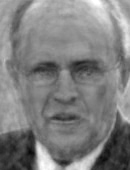

In [67]:
train_size = len(train["labels"])
pca_pixels = pca.inverse_transform(train_df)

for idx in [random.randint(0, train_size - 1) for cnt in range(10)]:
  label_id = train["labels"][idx]
  print("id:", label_id,
        "\nlabel:", LFWUtils.LABELS[label_id],
        "\nfrom:", train["files"][idx])
  display(make_image(train["pixels"][idx], width=130))
  display(make_image(pca_pixels.loc[idx], width=130))

### Interpretation

<span style="color:hotpink;">
Do these make sense ? Do they look "recognizable" ? How do they change as a function of <code>n_components</code> ?
</span>

When the n_components increase, the random images become more recognizable. I struggle to identify faces when it is only 100 vs 200 components. 

Now, back to classifying...

In [68]:
# TODO: create a classifier
# TODO: separate input and output columns from the train DataFrame(input is PCA dataframe and output labels)
# TODO: train model using train data and labels
# TODO: run prediction on train data
train_model = RandomForestClassifier()
train_features = train_df.drop(columns=["label"])
train_ids = train_df["label"]
train_model.fit(train_features, train_ids)
train_predictions = train_model.predict(train_features)

### Validate model with training data

We can use `classification_error(real_labels, predicted_labels)` to measure the classification error and `display_confusion_matrix(real_labels, predicted_labels, LFWUtils.LABELS)` to show the confusion matrix.

0.0


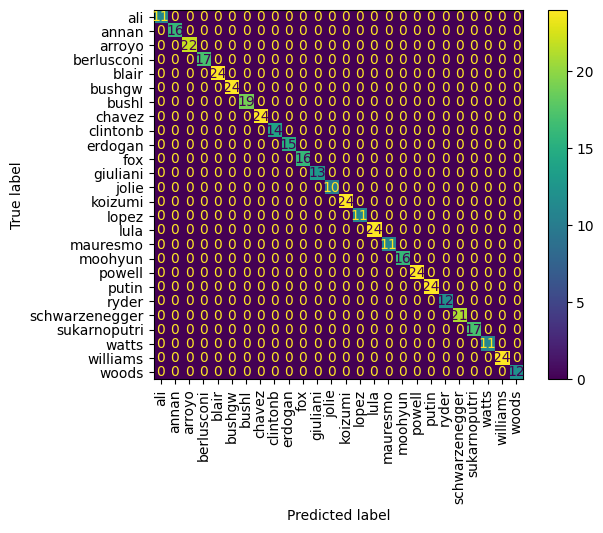

In [69]:
# measure classification error
print(classification_error(train["labels"], train_predictions))

# look at confusion matrix
display_confusion_matrix(train["labels"], train_predictions, LFWUtils.LABELS)

### Interpretation

<span style="color:hotpink;">
How does the confusion matrix look ? What does it mean ?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

If the `RandomForestClassifier` performs well on the training data, we can move on and run it on the `test` data.

If not, there are a couple of things we can try:
- adjust `PCA` parameters
- add more images to our dataset
- try a different type of classifier called `SVC`
- adjust the ratio of the `train`/`test` split and increase the number of training samples (but not past $60$ / $40$)

We don't want to `fit()` another `PCA` here, nor create another `RandomForestClassifier` object.

We already have the `PCA` components we need for the test dataset, probably in a variable called `test_df`.

In [70]:
# TODO: run prediction on test data
test_df = pca.transform(test['pixels'])
test_predictions = train_model.predict(test_df)

### Validate model with testing data

0.65625


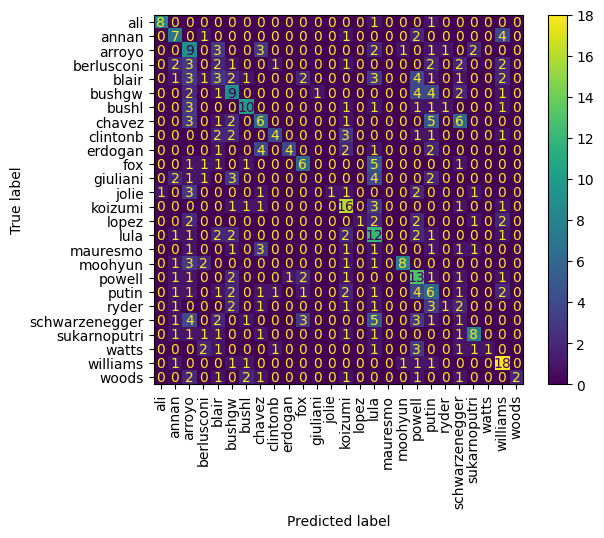

In [71]:
# measure classification error
print(classification_error(test["labels"], test_predictions))

# look at confusion matrix
display_confusion_matrix(test["labels"], test_predictions, LFWUtils.LABELS)

### Interpretation

<span style="color:hotpink;">
How does THIS confusion matrix look ? What does it mean ? How does it perform for your pictures ?
</span>

In the matrix, I see many false Positives and false negatives that will impact the face recognition model. However, on my face, it recognized 8 times with 1 error. My face does better than others in this confusion matrix

### Precision and Recall

Accuracy, which is the complement of our `classification_error` value, is the measurement that is optimized during the `RandomForestClassifier` training process.

If we were training a regular classifier, we would look at `accuracy` (or `classification_error`) to determine if our model's performance is acceptable.

Since we're working on a personal face recognition model, we don't really care about overall accuracy, but instead are more interested in the `precision` and `recall` values for the classification of our particular images.

We don't want overall accuracy to be horrible, but we can be more specific in this case and be happy if the correct portion of our confusion matrix looks good.

Calculate the `precision` and `recall` values for the classification of your images.

You can use some scikit-learn functions for this, but might be faster to just take a look [HERE](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall) or our [WK10 notebook](https://github.com/DM-GY-9103-2024F-H/WK10/blob/main/WK10.ipynb) to see how to calculate these from the confusion matrices.

In [72]:
# TODO: calculate precision
true_positives_ali = 8
false_positives_ali = 2
precision_ali = true_positives_ali / (true_positives_ali + false_positives_ali)
print(precision_ali)

# TODO: calculate recall
false_negatives_ali = 2
recall_ali=true_positives_ali / (true_positives_ali + false_negatives_ali)
print(recall_ali)


0.8
0.8


### Interpretation

<span style="color:hotpink;">
How is it performing for your images ? Which value, precision or recall, is higher ? What does that mean ?
</span>

Precision and recall are consistent for "ali", therefore they are balanced.

We can run the following cell to see which classes have the highest `precision` and `recall` scores:

In [73]:
display(LFWUtils.top_precision(test["labels"], test_predictions, top=5))
display(LFWUtils.top_recall(test["labels"], test_predictions, top=5))

[np.str_('woods'),
 np.str_('watts'),
 np.str_('jolie'),
 np.str_('lopez'),
 np.str_('ali')]

[np.str_('ali'),
 np.str_('williams'),
 np.str_('koizumi'),
 np.str_('powell'),
 np.str_('bushl')]

### Interpretation

<span style="color:hotpink;">
Did that analysis make you feel any better about your classifier ? Is your face in the top-5 precision classes ?
</span>

I was not in the top 5 precision class but am first in recall. Therefore suggesting that there are cases where my face caused a False Positives, resulting in more mistakes.

### Adjust

Do the `precision` and `recall` values seem acceptable ?

Which is more important in this case? (Keep in mind what a false positive might mean...)

A couple of things to try to improve the model:
- adjust `PCA` parameters
- add more images to our dataset
- try a different type of classifier called `SVC`
- adjust the ratio of the `train`/`test` split and increase the number of training samples (but not past $60$ / $40$)

## More Image/Audio Classification

We're going to re-visit the classification exercises from `HW04` and `HW06`, but will increment them with `PCA` and Clustering.

This exercise is a bit different though. In some ways it's the opposite of many of the other exercises we've done so far, but it's more representative of the type of work that goes into using real ML models in the wild.

So far, the code for loading data into datasets has mostly been provided, and you had to implement the steps necessary to create, fit and evaluate a model.

This time, the models are all set up, but you have to prepare the data that is necessary to fit/train them.

### Set Up

Let's start by importing some classes and functions that we will use.

In [74]:
from HW04_utils import HW04Utils, function as get_audio_label
from HW06_utils import HW06Utils, function as get_image_label
from HW10_utils import AwesomeAudioClassifier, AwesomeImageClassifier

AUDIO_PATH = "./data/sounds/instruments"
IMAGE_PATH = "./data/images/forests"

### The Models

We have two `Awesome` models, one for audio classification, and one for image classification. They both use `StandardScaler` and `PCA` to prepare the data for an eventual `SVC` classifier. The image classifier also uses `KMeanClustering` to get a reduced palette of colors for the classification.

They both inherit their interface from the same class: `AwesomeClassifier`. You can take a look inside `HW10_utils.py` for all the details, but this is the TL;DR:

- `AwesomeAudioClassifier(pca_components)`: this constructor takes $1$ argument, the number of `PCA` components to use.
- `AwesomeImageClassifier(pca_components, num_colors)`: this constructor takes $2$ arguments, the number of `PCA` components to use and the number of colors to use in clustering.
- `AwesomeClassifier.fit(features, labels)`: this function takes two `DataFrames`, one for the features to use in training and the other with the encoded labels of the features.
- `AwesomeClassifier.predict(features)`: once the model has been _fitted_ we can use this function to get predictions for our data.

And that's it. All pre-processing, scaling, `PCA`ing, clustering, fitting, etc is done inside the classes.

Once we have predictions we can use `classification_error(labels, predictions)` and `display_confusion_matrix(labels, predictions)` to evaluate our models.

There's code for running these steps below.

### The Data

Audio and Image files are in the `data/sounds/instruments` and `data/images/forests` directories respectively.

What you have to do is create `train` and `test` datasets with features and labels. These should be the output of calling the [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function with some `DataFrames`.

There are a couple of ways of doing this:
- `train_features, test_features, train_labels, test_labels = train_test_split(features_df, labels_df, test_size=0.5)`
- OR
- `train_df, test_df = train_test_split(data_df, test_size=0.5)`

In the first option, the input features and labels are already separated into $2$ `DataFrames`, while in the second option there's one `DataFrame` that has both features and label columns. If you use the second option you have to split `train_df` and `test_df` into features and labels `DataFrames` yourself.

### The Labels

A possible strategy to get the labels for all files is:

- As you're iterating through the files and reading their contents, the functions `get_audio_label()` and `get_image_label()` can be used to extract the correct label names from the filenames.
- The `L2I` (label to id) object can then be used to encode the labels into numeric values
  - `HW04Utils.L2I[get_audio_label("2122479.wav")]` should return $1$, for `guitar`
  - `HW06Utils.L2I[get_image_label("3150190.jpg")]` should return $0$, for `florist`

This should be enough for creating `DataFrame`s with labels.

### The Features

This is the challenging part.

Once you have opened the images/audios and extracted samples/pixels, you may try to create a `DataFrame` directly from those.

It might seem like it works, but if you take a look at the `DataFrame` you'll see some `NaN` values in some of the columns, and if you send that to the model it will barf and complain about `PCA` not liking `NaN`s in the data.

This happens because all of the audios and images have different sizes. Hoooray !!

Welcome to Machine Learning. This is probably where most of the time in any ML project is spent: cleaning up data and making sure it has the right format, size and shape that a model expects.

For this exercise it won't be too hard to fix these.

Let's start with the audio files since they're one-dimensional, and once we have the audio modeling working we'll come back to the image files.

### Audio Data

We can start with a little bit of code from `HW04` to get all of the filenames that end in `.wav` inside a given directory.

Then, we'll loop through the filenames, open them as lists of samples, and also save the labels associated with each file.

In [75]:
# List comprehension for getting all of the filenames that end in "wav" inside the audio directory
audio_files = [f for f in listdir(AUDIO_PATH) if f.endswith("wav")]

# To store samples and labels for each file
audio_labels = []
audio_samples = []

# Iterate through filenames, open files, append samples and labels
for fname in audio_files:
  audio_labels.append(HW04Utils.L2I[get_audio_label(fname)])
  audio_samples.append(wav_to_list(path.join(AUDIO_PATH, fname)))

### Fix Audio Data

We have the samples and labels. We can check what they look like and think of a way to make the list of samples more consistent.

When we're done, they should all have the same length.

In [76]:
# Length of lists
print(len(audio_labels), len(audio_samples))

target_length = len(audio_samples)
# Length of samples for first 5 files
for s in audio_samples[:5]:
  print(len(s))

127 127
86016
86822
87005
86293
87040


In [77]:
# TODO: go through the list of samples and make their lengths consistent
# def normalize_length(sample, target_length):
#     if len(sample) > target_length:
      
#         return sample[:target_length]
#     elif len(sample) < target_length:
#         # Pad shorter samples with zeros
#         padding = target_length - len(sample)
#         return np.pad(sample, (0, padding), mode='constant')
#     return sample  # Already the correct length

# # Normalize all samples
# normalized_samples = [normalize_length(s, target_length) for s in audio_samples]

# # Verify consistency
# print("All samples normalized to:", target_length)

samples_df = pd.DataFrame(audio_samples)
audio_labels_df = pd.DataFrame(audio_labels)
samples_df.fillna(0, inplace=True)
# TODO: create samples_df and audio_labels_df DataFrames for train_test_split
samples_df


,0,1,2,3,4,5,6,7,8,9,...,87077,87078,87079,87080,87081,87082,87083,87084,87085,87086
0,1084,1626,2303,3078,3901,4674,5251,5561,5678,5723,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9136,9312,9410,9468,9514,9569,9688,9842,9993,10089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,813,831,784,703,606,516,444,413,431,491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3074,3414,3674,3869,4011,4129,4239,4346,4445,4516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,888,862,816,756,682,587,489,379,271,169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,465,461,458,452,444,436,423,412,398,385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,2842,3262,3996,4856,5537,5838,5613,4955,4025,3008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124,-9578,-10345,-11027,-11673,-12230,-12530,-12548,-12515,-12402,-12122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,3761,3808,3826,3757,3897,4283,4534,4785,5332,5925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The `samples_df` and `audio_labels_df` should look something like this:

<img src="./imgs/samples_df.jpg" height="200px"/> and <img src="./imgs/audio_labels_df.jpg" height="200px"/>

### Create Datasets

Now we can run `train_test_split()` to create train and test `DataFrames` for our features and labels.

In [78]:
train_features, test_features, train_labels, test_labels = train_test_split(samples_df, audio_labels_df, test_size=0.5, random_state=1010)

### Run the Model

Now that we have train and test `DataFrame`s with consistent rows, we can fit and evaluate our model.

This cell creates a classifier model, fits it using the `train` dataset, and then makes predictions for both `train` and `test` datasets in order to calculate the classification error.

We just have to run it.

Explained Variance: 0.9567516385037286


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0
0.109375


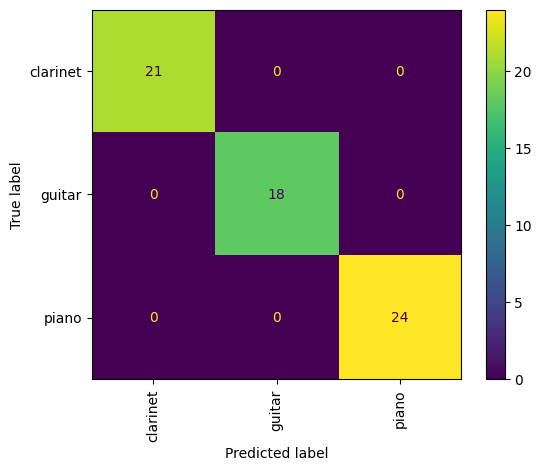

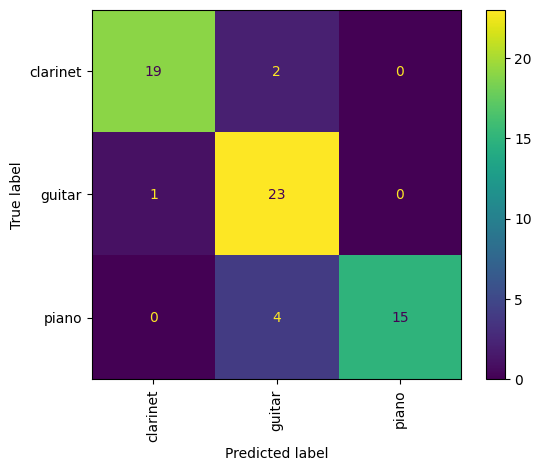

In [79]:
# Instantiate an audio classifier
mAAC = AwesomeAudioClassifier(24)

# Fit the classifier with training features and labels
mAAC.fit(train_features, train_labels)

# Predict labels for train and test data
train_predictions = mAAC.predict(train_features)
test_predictions = mAAC.predict(test_features)

# Evaluate predictions
print(classification_error(train_labels, train_predictions))
print(classification_error(test_labels, test_predictions))

display_confusion_matrix(train_labels, train_predictions, display_labels=HW04Utils.INSTRUMENTS)
display_confusion_matrix(test_labels, test_predictions, display_labels=HW04Utils.INSTRUMENTS)

### Image Data

This is a bit trickier, but, again, we can start with a little bit of code from `HW06` to get all of the filenames that end in `.jpg` inside a given directory.

Then, we'll loop through the filenames, open them as images, and also save the labels associated with each file.

In [80]:
# # TODO: get all of the filenames that end in "jpg" inside the image directory
image_files = [f for f in listdir(IMAGE_PATH) if f.endswith(".jpg")]
# # TODO: iterate through filenames, open files, store image objects and labels
# # Initialize lists to store pixel data and labels
pixel_data = []
label_data = []

for fname in image_files:
  label = get_image_label(fname)
  img = open_image(path.join(IMAGE_PATH, fname))
  im_s = img.crop((0, 0, 200,200))
  pixel_data.append(im_s.pixels)
  label_data.append(label)

In [81]:
# pixel_data[0].resize((800,800))

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import random

from os import listdir, path
from sklearn.model_selection import train_test_split

from audio_utils import wav_to_list

from data_utils import PCA, RandomForestClassifier, StandardScaler, SVC
from data_utils import classification_error, display_confusion_matrix
from data_utils import LFWUtils

from image_utils import make_image, open_image

from HW04_utils import HW04Utils, function as get_audio_label
from HW06_utils import HW06Utils, function as get_image_label
from HW10_utils import AwesomeAudioClassifier, AwesomeImageClassifier

AUDIO_PATH = "./data/sounds/instruments"
IMAGE_PATH = "./data/images/forests"

### Fix Image Data

We have the images and their labels. We can investigate what they look like and, before we extract their pixels, make the images more consistent.

When we're done, they should all have the same dimensions.

There are a couple of ways to achieve this:
- Slice: chop off the list of pixels.
- Crop: use the `image.crop()` function to cut the images.
- Resize: use `image.resize()` to stretch/squeeze the images into specific shapes.

Documentation for [`crop()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.crop) and [`resize()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize).

Take a look at a few images before picking a strategy and then take a look after to see what the chosen strategy does to the images.

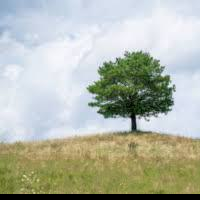

In [83]:
# TODO: look at characteristics/dimensions of the images
# image_files[:3]
# image_dimensions = []
# for fname in image_files[:3]:  # Process only the first 3 images
#     file_path = path.join(IMAGE_PATH, fname)
#     img = open_image(file_path)  # Open image
#     width, height = img.size  # Get dimensions
#     image_dimensions.append((fname, width, height))
# print(image_dimensions)
# TODO: go through the list of images and make their dimensions consistent

# TODO: look at some images
make_image(pixel_data[20])

### Create Image `DataFrames`

Once we have images of similar sizes, we can put their pixels into a `DataFrame` called `pixels_df`, and create another `DataFrame` called `image_labels_df` with image label data.

In [84]:
pixels_df = pd.DataFrame(pixel_data)
image_label_df = pd.DataFrame(label_data)
pixels_df

,0,1,2,3,4,5,6,7,8,9,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
0,"(43, 47, 32)","(10, 17, 0)","(18, 32, 6)","(33, 55, 19)","(55, 82, 41)","(38, 72, 22)","(12, 53, 0)","(75, 119, 58)","(64, 108, 45)","(125, 166, 106)",...,"(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)"
1,"(213, 215, 210)","(213, 215, 210)","(213, 215, 210)","(213, 215, 210)","(213, 215, 210)","(213, 215, 210)","(213, 215, 210)","(213, 215, 210)","(217, 219, 214)","(217, 219, 214)",...,"(206, 206, 196)","(214, 216, 205)","(207, 208, 200)","(208, 211, 204)","(208, 209, 203)","(217, 218, 212)","(204, 201, 196)","(111, 108, 103)","(208, 203, 199)","(210, 205, 201)"
2,"(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)",...,"(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)"
3,"(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)",...,"(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)"
4,"(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)",...,"(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,"(248, 248, 248)","(248, 248, 248)","(248, 248, 248)","(248, 248, 248)","(248, 248, 248)","(248, 248, 248)","(248, 248, 248)","(248, 248, 248)","(247, 247, 247)","(247, 247, 247)",...,"(78, 54, 67)","(78, 56, 68)","(73, 56, 64)","(83, 68, 75)","(99, 84, 91)","(98, 85, 92)","(82, 69, 76)","(92, 81, 87)","(163, 152, 158)","(240, 231, 236)"
176,"(73, 109, 107)","(73, 109, 107)","(75, 111, 109)","(78, 114, 112)","(85, 119, 120)","(92, 126, 127)","(99, 133, 134)","(103, 137, 138)","(113, 144, 147)","(110, 141, 144)",...,"(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)"
177,"(90, 137, 45)","(119, 166, 74)","(92, 137, 46)","(80, 125, 34)","(70, 113, 23)","(67, 110, 20)","(90, 133, 44)","(63, 105, 19)","(60, 98, 15)","(84, 121, 43)",...,"(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)"
178,"(97, 151, 211)","(97, 151, 211)","(97, 151, 211)","(98, 152, 212)","(98, 152, 212)","(99, 153, 213)","(99, 153, 213)","(99, 153, 213)","(99, 153, 213)","(99, 153, 213)",...,"(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)"


In [85]:
# TODO: create DataFrames pixels_df from image pixels and image_labels_df from the file labels

The `pixels_df` and `image_labels_df` should look something like this:

<img src="./imgs/pixels_df.jpg" height="350px"/> and <img src="./imgs/image_labels_df.jpg" height="350px"/>

### Create train/test datasets

Now we can run `train_test_split()` to create train and test `DataFrames` for our pixels and labels.

In [86]:
# TODO: use train_test_split() to create train and test DataFrames
train_features, test_features, train_labels, test_labels = train_test_split(pixels_df, image_label_df, test_size=0.5, random_state=1010)

### Run the Image Model

Now that we have train and test `DataFrame`s with consistent rows, we can fit and evaluate our model.

The exact variable names might be different, but you should have $4$ `DataFrames` at this point:
`train_features`, `test_features`, `train_labels`, and `test_labels`.

These were either all returned by `train_test_split()`, or you manually split up the result of `train_test_split()` into `train` and `test` datasets.

The following cell creates a classifier model, fits it using the `train` dataset, and then makes predictions for both `train` and `test` datasets in order to calculate the classification error.

We just have to run it.

Explained Variance: 0.9632095854012299


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0
0.07777777777777772


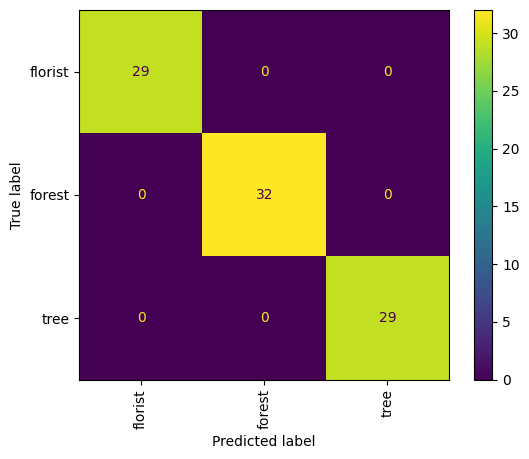

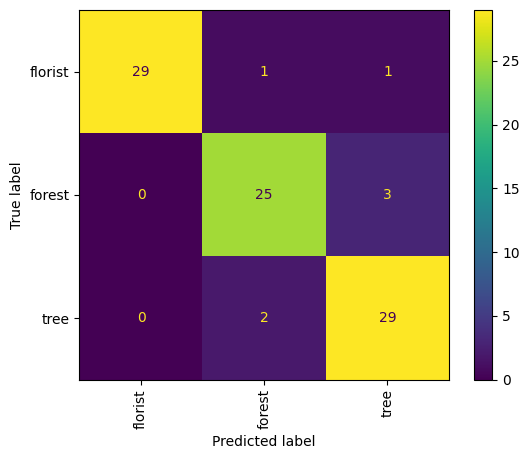

In [87]:
# Instantiate an image classifier
mAIC = AwesomeImageClassifier(64, 8)

# Fit the classifier with training features and labels
mAIC.fit(train_features, train_labels)

# Predict labels for train and test data
train_predictions = mAIC.predict(train_features)
test_predictions = mAIC.predict(test_features)

# Evaluate predictions
print(classification_error(train_labels, train_predictions))
print(classification_error(test_labels, test_predictions))

display_confusion_matrix(train_labels, train_predictions, display_labels=HW06Utils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=HW06Utils.LABELS)